In [1]:
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))

from sklearn.model_selection import train_test_split
from bart_playground import *
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn.datasets import fetch_california_housing

data = fetch_california_housing(as_frame=True)

X = data.data
y = data.target

X = X.values.astype(float)
y = np.array(y).reshape(-1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [3]:
import arviz as az

n_chains = 4
ndpost = 1000
nskip = 100
n_trees = 100
proposal_probs_mtmh = {"multi_grow": 0.25, "multi_prune": 0.25, "multi_change": 0.4, "multi_swap": 0.1}

rhat_feature_mtmh = []

chains_ratios_mtmh = []
for i in range(n_chains):
    bart = MultiBART(ndpost=ndpost, nskip=nskip, n_trees=n_trees,
                        proposal_probs=proposal_probs_mtmh, multi_tries=10, random_state=i)
    bart.fit(X_train, y_train)
    # Count feature split ratio for each trace
    feature_ratios_per_trace = []
    for trace in bart.trace:
        feature_counts = {}
        for tree in trace.trees:
            for var in tree.vars:
                if var >= 0:
                    feature_counts[var] = feature_counts.get(var, 0) + 1
        total = sum(feature_counts.values())
        if total == 0:
            ratios = {var: 0 for var in feature_counts}
        else:
            ratios = {var: count / total for var, count in feature_counts.items()}
        feature_ratios_per_trace.append(ratios)
    # Organize into matrix: each variable is a row, each trace is a column
    all_vars = sorted({v for ratios in feature_ratios_per_trace for v in ratios.keys()})
    matrix = []
    for var in all_vars:
        matrix.append([ratios.get(var, 0) for ratios in feature_ratios_per_trace])
    chains_ratios_mtmh.append(matrix)
# chains_ratios: shape [n_chains, n_vars, n_traces]
chains_ratios_mtmh = np.array(chains_ratios_mtmh)  # shape: (n_chains, n_vars, n_traces)
# Convert to arviz data structure
# Required shape: (chain, draw, var)
chains_ratios_mtmh = np.transpose(chains_ratios_mtmh, (0, 2, 1))  # (chain, draw, var)
idata = az.from_dict(posterior={"feature_ratio": chains_ratios_mtmh})
rhat = az.rhat(idata, var_names=["feature_ratio"])
rhat_feature_mtmh.append(rhat["feature_ratio"].values)  # shape: (n_vars,)

INFO:arviz.preview:arviz_base not installed
INFO:arviz.preview:arviz_stats not installed
INFO:arviz.preview:arviz_plots not installed
Iterations: 100%|██████████| 1100/1100 [04:19<00:00,  4.23it/s]


In [4]:
# Compute Rhat for feature selection ratios for DefaultBART
rhat_feature_default = []

chains_ratios_default = []
for i in range(n_chains):
    bart = DefaultBART(ndpost=ndpost, nskip=nskip, n_trees=n_trees,
                       proposal_probs={"grow": 0.25, "prune": 0.25, "change": 0.4, "swap": 0.1}, random_state=i)
    bart.fit(X_train, y_train)
    # Count feature split ratio for each trace
    feature_ratios_per_trace = []
    for trace in bart.trace:
        feature_counts = {}
        for tree in trace.trees:
            for var in tree.vars:
                if var >= 0:
                    feature_counts[var] = feature_counts.get(var, 0) + 1
        total = sum(feature_counts.values())
        if total == 0:
            ratios = {var: 0 for var in feature_counts}
        else:
            ratios = {var: count / total for var, count in feature_counts.items()}
        feature_ratios_per_trace.append(ratios)
    # Organize into matrix: each variable is a row, each trace is a column
    all_vars = sorted({v for ratios in feature_ratios_per_trace for v in ratios.keys()})
    matrix = []
    for var in all_vars:
        matrix.append([ratios.get(var, 0) for ratios in feature_ratios_per_trace])
    chains_ratios_default.append(matrix)
# chains_ratios_default: shape [n_chains, n_vars, n_traces]
chains_ratios_default = np.array(chains_ratios_default)  # shape: (n_chains, n_vars, n_traces)
# Convert to arviz data structure
# Required shape: (chain, draw, var)
chains_ratios_default = np.transpose(chains_ratios_default, (0, 2, 1))  # (chain, draw, var)
idata_default = az.from_dict(posterior={"feature_ratio": chains_ratios_default})
rhat_default = az.rhat(idata_default, var_names=["feature_ratio"])
rhat_feature_default.append(rhat_default["feature_ratio"].values)  # shape: (n_vars,)

Iterations: 100%|██████████| 1100/1100 [00:27<00:00, 39.83it/s]


In [5]:
# Print Rhat for each feature
print("Rhat for each feature (MultiBART):", rhat_feature_mtmh[0])
print("Rhat for each feature (DefaultBART):", rhat_feature_default[0])

Rhat for each feature (MultiBART): [1.45754044 1.38104788 1.59957345 1.34116381 1.36668572 1.30803656
 1.76214042 1.74292044]
Rhat for each feature (DefaultBART): [1.51319796 1.39071281 1.33215292 1.11415231 1.16302079 1.11952574
 1.98788169 1.42774451]


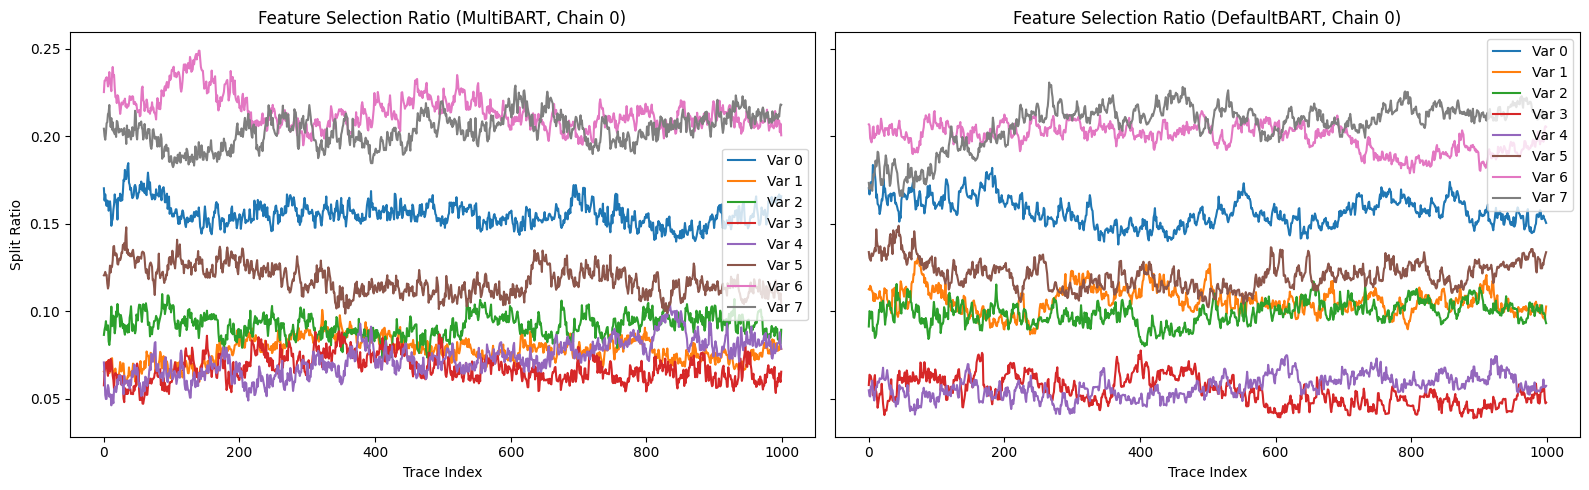

In [6]:
# Plot feature selection ratios for chain 0 for both MultiBART and DefaultBART
fig, axes = plt.subplots(1, 2, figsize=(16, 5), sharey=True)

# MultiBART plot (chain 0)
for idx in range(chains_ratios_mtmh.shape[2]):
    axes[0].plot(chains_ratios_mtmh[0, :, idx], label=f'Var {idx}')
axes[0].set_xlabel('Trace Index')
axes[0].set_ylabel('Split Ratio')
axes[0].set_title('Feature Selection Ratio (MultiBART, Chain 0)')
axes[0].legend()

# DefaultBART plot (chain 0)
for idx in range(chains_ratios_default.shape[2]):
    axes[1].plot(chains_ratios_default[0, :, idx], label=f'Var {idx}')
axes[1].set_xlabel('Trace Index')
axes[1].set_title('Feature Selection Ratio (DefaultBART, Chain 0)')
axes[1].legend()

plt.tight_layout()
plt.show()